# Abnormality Detection in Bone X-Rays

> *Deep Learning*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

##### *Description*

<p style='text-align: justify;'>Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. You must use at least 2 different architectures, one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and one with a popular pre-trained CNN model (e.g., VGG-19, ResNet, etc.). Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found at <a href="https://stanfordmlgroup.github.io/competitions/mura/">https://stanfordmlgroup.github.io/competitions/mura/</a>. To download the dataset you must first fill out a form.</p>

You can find the Google Colab link [here.](https://colab.research.google.com/drive/1BGue9oV1t5Kqw0FikC7ex4ytF4mmZCTc)

## *Table of Contents*

- [*1. Introduction*](#introduction)
    - [*1.1. Libraries*](#libraries)
    - [*1.2. Data*](#data)
    - [*1.3. Data Preparation*](#data_preparation)
    - [*1.4. Data Preprocessing*](#data_preprocessing)
- [*2. CNN*](#cnn)
    - [*2.1. Model Architecture*](#model_architecture)
    - [*2.2. Metrics*](#metrics)
    - [*2.3. Callbacks*](#callbacks)
    - [*2.4. Model Training*](#model_training)
    - [*2.5. Model Evaluation*](#model_evaluation)

---

# *Introduction*

## *Libraries*

- *Install any required packages*
- *Import libraries*

##### *Install packages*

In [1]:
!pip install -U tensorflow-addons -q

##### *Import libraries*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc
import zipfile
from sklearn.model_selection import train_test_split
import time
import random

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras import backend as K # importing Keras backend (by default it is Tensorflow)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow_addons.metrics import CohenKappa

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.11.0


##### *Initialize some variables needed in order to have reproducible experiments*

In [3]:
SEED = 2023
np.random.seed(SEED) # seed for numpy to have reproducible experiments
set_seed(SEED) # seed for Tensorflow to have reproducible experiments

##### *Define a function to clean up the model*

In [4]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

## *Data*

<p style='text-align: justify;'>The MURA dataset is a large-scale dataset of musculoskeletal radiographs that was released by Stanford University in 2017. The acronym "MURA" stands for "musculoskeletal radiographs" and the dataset contains over 40,000 digital X-ray images covering seven different body parts, including the wrist, elbow, shoulder, finger, hip, knee, and ankle.</p>

<p style='text-align: justify;'>The purpose of the MURA dataset is to enable the development of machine learning models that can automatically detect abnormalities in musculoskeletal radiographs. This is a challenging task because abnormalities can be subtle and difficult for even trained human radiologists to detect.</p>

<p style='text-align: justify;'>The MURA dataset has become a popular benchmark for evaluating the performance of deep learning models in musculoskeletal radiograph analysis. It has been used in a number of research studies and competitions to develop and test algorithms for detecting fractures, dislocations, and other abnormalities in X-ray images.</p>

##### *Download MURA dataset*

In [5]:
# download the data in zip format
!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip'

--2023-03-26 17:17:38--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip.1’

MURA-v1.1.zip.1     100%[===================>]   3.15G  13.5MB/s    in 4m 2s   

2023-03-26 17:21:40 (13.3 MB/s) - ‘MURA-v1.1.zip.1’ saved [3380245855/3380245855]



##### *Unzip the dataset*

In [6]:
# what's the filename?
filename = 'MURA-v1.1.zip'

# unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

##### *Get the filepath for the training and test sets*

In [7]:
# what's the filepath?
filepath = 'MURA-v1.1'

# get train and test set filepaths
train_set_filepath = os.path.join(filepath, 'train_image_paths.csv')
test_set_filepath = os.path.join(filepath, 'valid_image_paths.csv')

## *Data Preparation*

*In this step, we will take the following actions:*

- *1. Load training and test data using the filepaths obtained above*
- *2. Split training data into training (80%) and validation (20%) sets*

##### *Define a function to load the data and create any required columns*

In [8]:
def load_data(filepath:str):

    # load data into a dataframe
    df = pd.read_csv(filepath, header=None, names=['image_path'])

    # create a description of the study of each image
    df['description'] = df.image_path.apply(lambda x: '_'.join(x.split('/')[2:5])[3:])

    # get the type of each study (e.g., elbow, shoulder, etc.)
    df['type'] = df.description.apply(lambda x: x.split('_')[0])

    # get the patient code of each study
    df['patient'] = df.description.apply(lambda x: x.split('_')[1])

    # get the code of each study
    df['study'] = df.description.apply(lambda x: x.split('_')[2])

    # get the opinion of each study
    df['opinion'] = df.description.apply(lambda x: x.split('_')[3])

    # create the label
    df['label'] = np.where(df.opinion == 'positive',1,0)

    return df

##### *Load training data*

In [9]:
# load training data
train_set = load_data(train_set_filepath)

# shape
print(f'train_set.shape: {train_set.shape}')

# preview
train_set.head()

train_set.shape: (36808, 7)


,image_path,description,type,patient,study,opinion,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER_patient00001_study1_positive,SHOULDER,patient00001,study1,positive,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER_patient00001_study1_positive,SHOULDER,patient00001,study1,positive,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER_patient00001_study1_positive,SHOULDER,patient00001,study1,positive,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER_patient00002_study1_positive,SHOULDER,patient00002,study1,positive,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER_patient00002_study1_positive,SHOULDER,patient00002,study1,positive,1


##### *Visualize the distribution of normal and abnormal case studies according to each type of the fracture in training set*

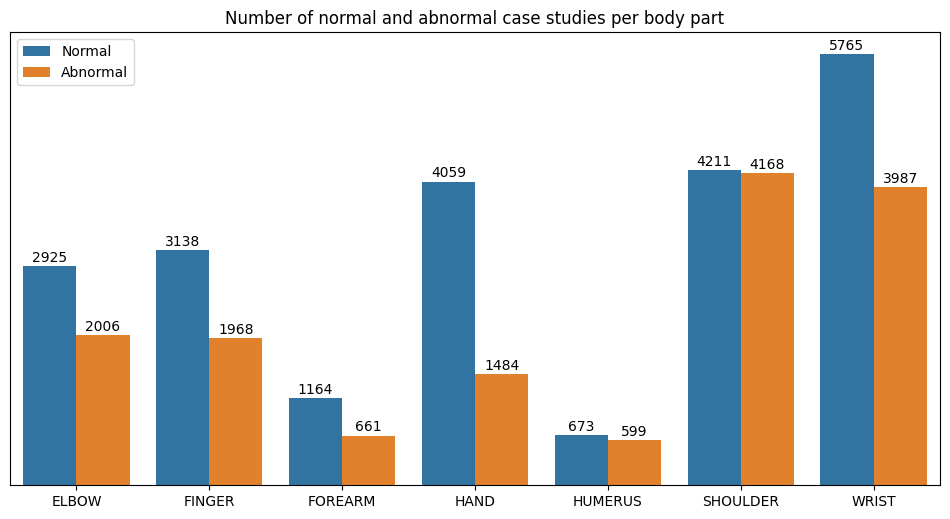

In [10]:
plt.figure(figsize=(12,6),dpi=100)
ax = sns.countplot(data=train_set, x=train_set['type'].sort_values(), hue=train_set['label'])
ax.bar_label(ax.containers[0], padding=1)
ax.bar_label(ax.containers[1], padding=1)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title('Number of normal and abnormal case studies per body part')
plt.legend(loc=0, labels=['Normal','Abnormal'])
plt.savefig('distribution_of_case_studies_per_body_part_train.svg')
plt.show()

##### *Load test data*

In [11]:
# load test data
test_set = load_data(test_set_filepath)

# shape
print(f'test_set.shape: {test_set.shape}')

# preview
test_set.head()

test_set.shape: (3197, 7)


,image_path,description,type,patient,study,opinion,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST_patient11185_study1_positive,WRIST,patient11185,study1,positive,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST_patient11185_study1_positive,WRIST,patient11185,study1,positive,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST_patient11185_study1_positive,WRIST,patient11185,study1,positive,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST_patient11185_study1_positive,WRIST,patient11185,study1,positive,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,WRIST_patient11186_study1_positive,WRIST,patient11186,study1,positive,1


##### *Define a function to split training data into train (80%) and validation (20%) sets*

In [12]:
def train_validation_split(dataset:pd.DataFrame):

    # define x and y
    x = dataset.drop(columns='label')
    y = dataset.label

    # split into training and validation sets
    x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                          y,
                                                          test_size=0.2,
                                                          shuffle=True,
                                                          stratify=dataset[['label','type']],
                                                          random_state=1)
    
    # concat x and y sets
    train_set = pd.concat([x_train, y_train], axis=1)
    valid_set = pd.concat([x_valid, y_valid], axis=1)

    # preview the sizes
    print(f'train_set.shape: {train_set.shape}')
    print(f'valid_set.shape: {valid_set.shape}')

    return train_set, valid_set

##### *Split training data into train (80%) and validation (20%) sets*

In [13]:
# execute function
train_set, valid_set = train_validation_split(train_set)

train_set.shape: (29446, 7)
valid_set.shape: (7362, 7)


##### *Visualize the distribution of the case studies according to each type of the fracture in training and validation sets*

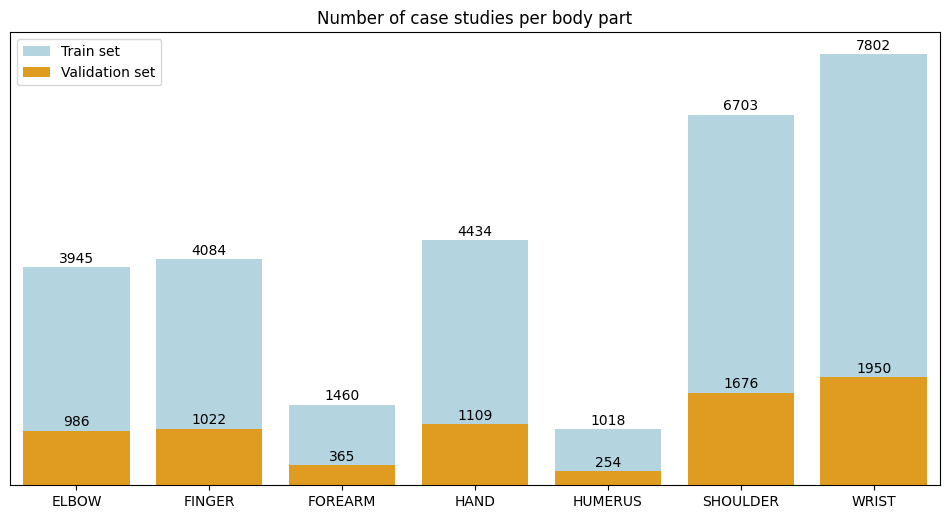

In [14]:
plt.figure(figsize=(12,6),dpi=100)
ax = sns.countplot(data=train_set, x=train_set['type'].sort_values(), color='lightblue', label='Train set')
ax.bar_label(ax.containers[0], padding=1)
ax = sns.countplot(data=valid_set, x=valid_set['type'].sort_values(), color='orange', label='Validation set')
ax.bar_label(ax.containers[1], padding=1)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])
plt.title('Number of case studies per body part')
plt.legend()
plt.savefig('number_of_case_studies_per_body_part_train.svg')
plt.show()

## *Data Preprocessing*

- *MURA dataset of the bone abnormalities consist of the large variety of the diﬀerent pictures with the diﬀerent formats and sizes*
- *Thus, one of the problems is the necessity to preprocess the images and make the data more homogeneous*
- *For this reason, we will take the following image preprocessing steps*
- *We will resize the images to a consistent size (224x224), since standardizing image size is important for training machine learning models*
- *We will augment the dataset using the following data augmentation approaches:*
  - *Random rotation of the images up to 30 degrees*
  - *Randomly changing brightness in the range 80-120 per cent*
  - *Random flipping the images horizontally*
  - *Randomly scaling in the range 95-130 per cent*
- *In this step, we will use `tf.keras.preprocessing.image.ImageDataGenerator`*
- *This will generate batches of tensor image data with real-time data augmentation*
- *We will apply all the aforementioned transformations only in the training set*
- *The only transformation that we will also apply to both validation and test sets is resizing the image*
- *The reason is to avoid data leakage and introducing bias into the models.*

##### *ImageDataGenerator for training data*

In [15]:
# create ImageDataGenerator object
train_image_data_gen = ImageDataGenerator(
    rotation_range=30,
    brightness_range=(0.8,1.2),
    horizontal_flip=True,
    rescale=random.uniform(0.95,1.3), # select random number between 0.95 and 1.3
    preprocessing_function=preprocess_input
)

# generate images
train_data_gen = train_image_data_gen.flow_from_dataframe(
    train_set,
    x_col='image_path',
    y_col='label',
    target_size=(224,224), # the dimensions to which all images found will be resized
    class_mode='raw', # numpy array of values in y_col column, need to use this if values in y_col are of type int
    batch_size=64, # size of the batches of data
    shuffle=True,
    seed=SEED
)

Found 29446 validated image filenames.


##### *ImageDataGenerator for validation data*

In [16]:
# create ImageDataGenerator object
valid_image_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# generate images
valid_data_gen = valid_image_data_gen.flow_from_dataframe(
    valid_set,
    x_col='image_path',
    y_col='label',
    target_size=(224,224), # the dimensions to which all images found will be resized
    class_mode='raw', # numpy array of values in y_col column, need to use this if values in y_col are of type int
    batch_size=64, # size of the batches of data
    shuffle=True,
    seed=SEED
)

Found 7362 validated image filenames.


##### *ImageDataGenerator for test data*

In [17]:
# create ImageDataGenerator object
test_image_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# generate images
test_data_gen = test_image_data_gen.flow_from_dataframe(
    test_set,
    x_col='image_path',
    y_col='label',
    target_size=(224,224), # the dimensions to which all images found will be resized
    class_mode='raw', # numpy array of values in y_col column, need to use this if values in y_col are of type int
    batch_size=64, # size of the batches of data
    shuffle=False,
    seed=SEED
)

Found 3197 validated image filenames.


# CNN

<p style='text-align: justify;'>CNNs (Convolutional Neural Networks) are a type of neural network commonly used for image classification and recognition tasks. They are designed to effectively capture spatial features in the input data by using convolutional layers that apply a set of filters to the input, followed by pooling layers that reduce the dimensionality of the output.</p>

<p style='text-align: justify;'>One of the key advantages of CNNs is their ability to learn hierarchical representations of the input data, allowing them to capture complex relationships between features. This makes them particularly useful for tasks where there are multiple levels of abstraction in the input data.</p>

## *Model Architecture*

- *Input Layer*
- *1 set of:*
    - *Conv2D Layer*
    - *Batch Normalization Layer*
    - *MaxPool2D Layer*
- *Flatten Layer*
- *Dropout Layer*
- *Dense Layer*
- *Batch Normalization Layer*
- *Dropout Layer*
- *Output Dense Layer*

## *Metrics*

- *We will track the performance of our models using two metrics*
- *In particular, we will use the `Loss` and `Accuracy`*

##### *Define a function to build a custom CNN model*

In [18]:
def build_model(input_shape:tuple=(224,224,3),
                learning_rate:float=1e-4,
                conv_layers:int=1, # number of convolutional layers
                conv_units:int=32, # number of neurons per convolutional layer
                conv_activation:str='relu', # activation function for convolutional layers
                hidden_dropout_prob:float=0.5, # dropout probability for neurons in hidden layers
                hidden_units:int=256, # number of neurons per hidden layer
                hidden_activation:str='relu', # activation function for hidden layers
                output_activation:str='sigmoid', # activation function for output layer
                metrics:list=['accuracy']
               ):

    # define the input layer
    input = Input(
            shape=input_shape, # input shape (number of features)
            name='Input'
    )
    x = input
    
    # define the convolutional layers
    for i in range(conv_layers):
        
        cnt = i # keep track of i
        
        # add conv2d layer
        x = Conv2D(
            filters=conv_units*(2**i),
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            dilation_rate=(1,1),
            activation=conv_activation,
            name=f'Conv2D-{i+1}'
        )(x)
        
        # add a batch normalization layer
        x = BatchNormalization(
            name=f'BatchNormalization-{i+1}'
        )(x)
        
        # add max pooling layer
        x = MaxPool2D(
            pool_size=(2,2),
            strides=(2,2),
            padding='same',
            name=f'MaxPool2D-{i+1}'
        )(x)
    
    # flatten the convoled images
    # so as to input them to a Dense Layer
    x = Flatten(
        name='Flatten'
    )(x)
    
    # add dropout layer
    x = Dropout(
        rate=hidden_dropout_prob,
        name=f'Dropout-1'
    )(x)
    
    # add another dense layer
    # before the output layer
    x = Dense(
        units=hidden_units,
        kernel_initializer='glorot_uniform',
        activation=hidden_activation,
        name=f'Dense-1'
    )(x)
    
    # add a batch normalization layer
    x = BatchNormalization(
        name=f'BatchNormalization-{cnt+2}'
    )(x)
    
    # add dropout layer
    x = Dropout(
        rate=hidden_dropout_prob,
        name=f'Dropout-2'
    )(x)
        
    # define the output layer
    output = Dense(
             units=1, # predicted outcome
             kernel_initializer='glorot_uniform',
             activation=output_activation,
             name='Output'
    )(x)

    # define the model
    model = Model(inputs=input, outputs=output)
    
    # add L2 regularization to the convolutional and fully connected layers
    l2_reg = l2(0.01)
    for layer in model.layers:
        if isinstance(layer, Conv2D) or isinstance(layer, Dense):
            layer.kernel_regularizer = l2_reg
            
    # compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=metrics)
    
    return model

## *Callbacks*

- *We will also use callbacks to gain a little more control over the training process*
- *In particular, we will use two callbacks, `EarlyStopping` and `ReduceLROnPlateau`*
- *`EarlyStopping` will help monitor the progress of the training and stop it in case there is no progress over a few epochs*
- *`ReduceLROnPlateau` will monitor the progress of the training and change the learning rate in case there is no progress over a few epochs*

##### *Define callbacks*

In [19]:
# define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1)

# define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    mode='min',
    factor=0.1,
    min_lr=1e-10,
    verbose=1)

# define callbacks
CALLBACKS = [early_stopping, reduce_lr]

## *Model Training*

- *In this step, we will train our model*
- *We will use the CNN model architecture mentioned previously*
- *Thus, we will define a function along with some default parameters to help us train the model*

##### *Define a function to train the model*

In [22]:
def train_model(train_data,
                valid_data,
                input_shape:tuple=(224,224,3),
                learning_rate:float=1e-4,
                conv_layers:int=1, # number of convolutional layers
                conv_units:int=32, # number of neurons per convolutional layer
                conv_activation:str='relu', # activation function for convolutional layers
                hidden_dropout_prob:float=0.5, # dropout probability for neurons in hidden layers
                hidden_units:int=256, # number of neurons per hidden layer
                hidden_activation:str='relu', # activation function for hidden layers
                output_activation:str='softmax', # activation function for output layer
                metrics:list=['accuracy'],
                batch_size=128,
                epochs=20,
                verbose=1,
                callbacks:list=None
               ):
    
    # build the model
    model = build_model(input_shape,
                        learning_rate,
                        conv_layers, # number of convolutional layers, if 0 then equal to LogReg
                        conv_units, # number of neurons per convolutional layer
                        conv_activation, # activation function for convolutional layers
                        hidden_dropout_prob, # boolean to define whether to add dropout
                        hidden_units, # number of neurons per hidden layer
                        hidden_activation, # activation function for hidden layers
                        output_activation, # activation function for output layer
                        metrics
                       )
    
    print('Started training.')
    print('-----------------')
    print()
    
    # train the model
    hs = model.fit(x=train_data,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=verbose,
                   callbacks=callbacks,
                   validation_data=valid_data
                  )
    
    print()
    print('Finished training.')
    print('------------------')
    print()
    
    return model, hs

##### *Train the model*

In [23]:
# start time
st = time.time()

# execute function to train the model
cnn_model, cnn_hs = train_model(train_data=train_data_gen,
                                valid_data=valid_data_gen,
                                epochs=5,
                                callbacks=CALLBACKS
                               )

# end time
et = time.time()

print(f'Elapsed time: {int(et-st)} secs.')

Started training.
-----------------

Epoch 1/5
461/461 [==============================] - 591s 1s/step - loss: 0.8320 - accuracy: 0.4041 - val_loss: 0.7104 - val_accuracy: 0.4041 - lr: 1.0000e-04
Epoch 2/5
461/461 [==============================] - 520s 1s/step - loss: 0.7771 - accuracy: 0.4041 - val_loss: 0.6448 - val_accuracy: 0.4041 - lr: 1.0000e-04
Epoch 3/5
461/461 [==============================] - 505s 1s/step - loss: 0.7560 - accuracy: 0.4041 - val_loss: 0.6639 - val_accuracy: 0.4041 - lr: 1.0000e-04
Epoch 4/5
461/461 [==============================] - 507s 1s/step - loss: 0.7342 - accuracy: 0.4041 - val_loss: 0.6558 - val_accuracy: 0.4041 - lr: 1.0000e-04
Epoch 5/5
461/461 [==============================] - 505s 1s/step - loss: 0.7311 - accuracy: 0.4041 - val_loss: 0.6486 - val_accuracy: 0.4041 - lr: 1.0000e-04

Finished training.
------------------

Elapsed time: 2784 secs.


##### *Preview model summary*

In [24]:
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 BatchNormalization-1 (Batch  (None, 224, 224, 32)     128       
 Normalization)                                                  
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 112, 112, 32)      0         
                                                                 
 Flatten (Flatten)           (None, 401408)            0         
                                                                 
 Dropout-1 (Dropout)         (None, 401408)            0         
                                                           

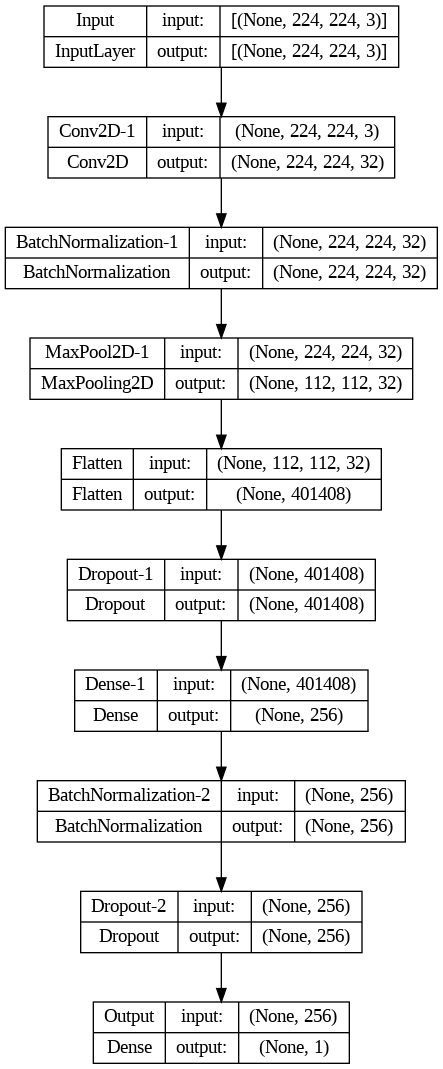

In [25]:
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

## *Model Evaluation*

- *In this step, we will evaluate the performance of our model*
- *In particular, we will evaluate its performance both during the training phase and making predictions*
- *For this reason, we will create a function which will help us to plot the learning curves*

##### *Define a function to plot learning curves*

In [26]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.savefig(f'cnn_learning_curves_{metric}.svg')
    plt.show()

##### *Evaluation on training and validation data*

In [27]:
epochs=10

CNN History Results:
---
Train Loss     : 0.73107
Validation Loss: 0.64861
---
Train Accuracy     : 0.40406
Validation Accuracy: 0.40410



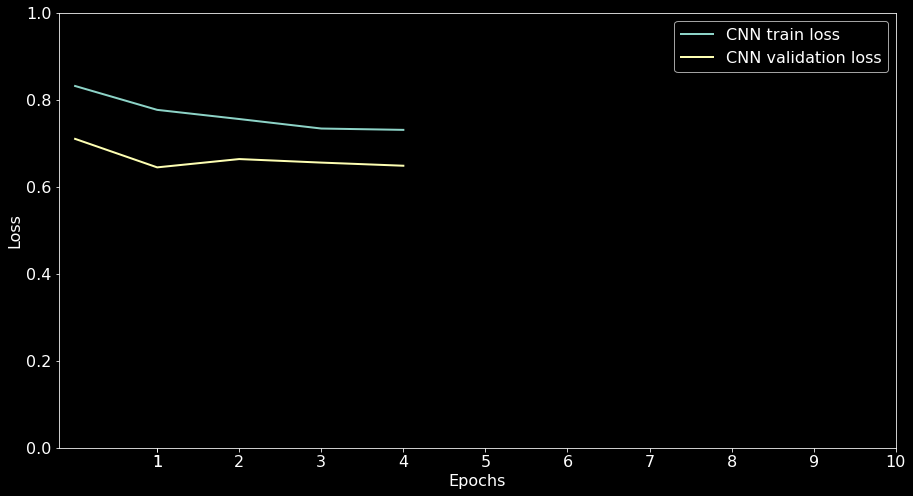

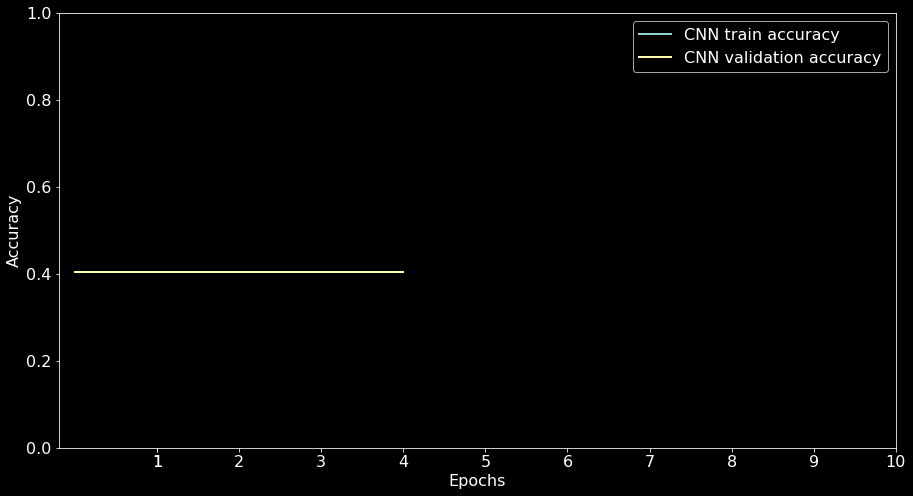

In [28]:
print("CNN History Results:")
print("---")
print("Train Loss     : {0:.5f}".format(cnn_hs.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(cnn_hs.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(cnn_hs.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(cnn_hs.history['val_accuracy'][-1]))

# plot train and validation error per epoch
plot_history(hs={'CNN': cnn_hs}, epochs=epochs, metric='loss')
plot_history(hs={'CNN': cnn_hs}, epochs=epochs, metric='accuracy')

##### *Evaluation on test data*

In [29]:
# evaluate on test data
model_eval = cnn_model.evaluate(test_data_gen, verbose=2)

# print results
print()
print("Test Loss         : {0:.5f}".format(model_eval[0]))
print("Test Accuracy     : {0:.5f}".format(model_eval[1]))

50/50 - 20s - loss: 0.6671 - accuracy: 0.4786 - 20s/epoch - 391ms/step

Test Loss         : 0.66706
Test Accuracy     : 0.47857


##### *Evaluation On Each Study Type*

In [30]:
# make predictions
predictions = cnn_model.predict(test_data_gen)

50/50 [==============================] - 16s 316ms/step


##### *Define a function to evaluate the predictions for each study type*

In [31]:
def evaluate_each_study_type(test_set, predictions):

    # append predictions to the test set
    test_set['predictions'] = predictions.ravel()
    test_set['predictions'] = np.where(test_set.predictions >= 0.5,1,0)

    # list of distinct study types
    study_types = sorted(test_set['type'].unique().tolist())

    # loop through study types
    for i, st in enumerate(study_types):

        # keep records of the current study type
        df_t = test_set[test_set['type']==st]

        # evaluate model performance on the current study type
        precision = precision_score(df_t.label.values, df_t.predictions.values)
        recall = recall_score(df_t.label.values, df_t.predictions.values)
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = accuracy_score(df_t.label.values, df_t.predictions.values)
        roc_auc = roc_auc_score(df_t.label.values, df_t.predictions.values)
        cohen_kappa = cohen_kappa_score(df_t.label.values, df_t.predictions.values)

        # print results
        print(f"{i+1} - Study Type: {st}")
        print("------------------------")
        print(f"    Precision: {round(precision,5)}")
        print(f"       Recall: {round(recall,5)}")
        print(f"     F1 Score: {round(f1_score,5)}")
        print(f"     Accuracy: {round(accuracy,5)}")
        print(f"      ROC AUC: {round(roc_auc,5)}")
        print(f"Cohen's Kappa: {round(cohen_kappa,5)}")
        print("========================")
        print()

In [32]:
evaluate_each_study_type(test_set, predictions)

1 - Study Type: ELBOW
------------------------
    Precision: 0.49462
       Recall: 1.0
     F1 Score: 0.66187
     Accuracy: 0.49462
      ROC AUC: 0.5
Cohen's Kappa: 0.0

2 - Study Type: FINGER
------------------------
    Precision: 0.53579
       Recall: 1.0
     F1 Score: 0.69774
     Accuracy: 0.53579
      ROC AUC: 0.5
Cohen's Kappa: 0.0

3 - Study Type: FOREARM
------------------------
    Precision: 0.50166
       Recall: 1.0
     F1 Score: 0.66814
     Accuracy: 0.50166
      ROC AUC: 0.5
Cohen's Kappa: 0.0

4 - Study Type: HAND
------------------------
    Precision: 0.41087
       Recall: 1.0
     F1 Score: 0.58243
     Accuracy: 0.41087
      ROC AUC: 0.5
Cohen's Kappa: 0.0

5 - Study Type: HUMERUS
------------------------
    Precision: 0.48611
       Recall: 1.0
     F1 Score: 0.65421
     Accuracy: 0.48611
      ROC AUC: 0.5
Cohen's Kappa: 0.0

6 - Study Type: SHOULDER
------------------------
    Precision: 0.49378
       Recall: 1.0
     F1 Score: 0.66112
     Accura

---

*Thank you!*

---